* Постройте контуры
* Выполните сегментацию с помощью метода водораздела, используя различные предобработки изображения (морфологические), сравните результаты
* Протестируйте различные алгоритмы сегментации skimage, сравните результаты (качество и быстродействие)
* Сохраните анализ алгоритмов в презентации

In [1]:
PATH = "../content/drive/My Drive/Машинное зрение/18112020/"

In [2]:
import PIL
from PIL import Image
import PIL.ImageOps 
from pylab import * 
from scipy.ndimage import filters, measurements, morphology

from scipy.cluster.vq import *
from scipy.cluster.hierarchy import *
from PIL.ImageFilter import Color3DLUT
import cv2 
from skimage.filters import unsharp_mask
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed 
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

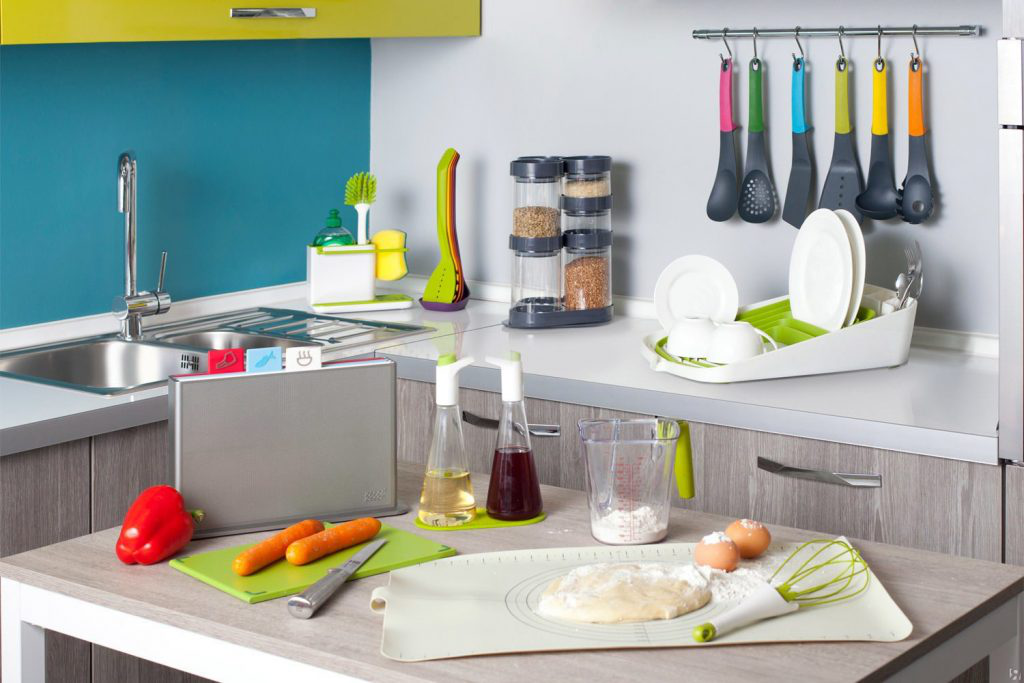

In [3]:
im = Image.open(PATH+'foto.jpg')
im

# Контуры

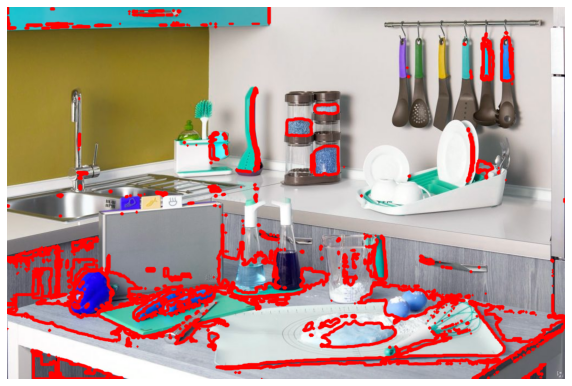

In [4]:
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)
fn = PATH+'foto.jpg' 
img = cv2.imread(fn)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
thresh = cv2.inRange(hsv, hsv_min, hsv_max) # применяем цветовой фильтр

# ищем контуры 
contours, hierarchy = cv2.findContours(thresh.copy(),
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)

# Отображаем контуры поверх изображения
cv2.drawContours(img, 
                 contours, 
                 -1, 
                 (255, 0, 0), 
                 3,
                 cv2.LINE_AA, 
                 hierarchy,
                 1)

figure(figsize=(10,10))
axis('off')
imshow(img)
#cv2.waitKey() # нажать любую клавишу, не закрывать окно х
#cv2.destroyAllWindows()

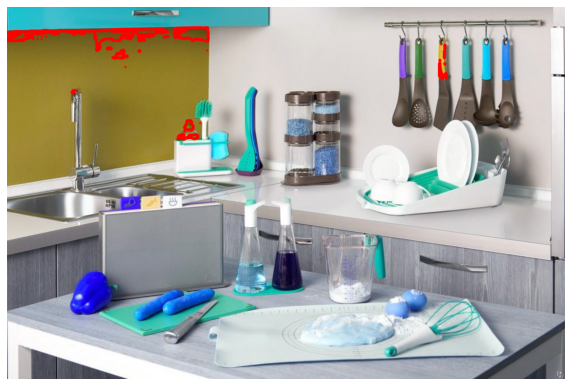

In [5]:
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)
fn = PATH+'foto.jpg' 
img = cv2.imread(fn)

hsv = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB) 
thresh = cv2.inRange(hsv, hsv_min, hsv_max) # применяем цветовой фильтр

# ищем контуры 
contours, hierarchy = cv2.findContours(thresh.copy(),
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_TC89_L1)

# Отображаем контуры поверх изображения
cv2.drawContours(img, 
                 contours, 
                 -1, 
                 (255, 0, 0), 
                 3,
                 cv2.LINE_AA, 
                 hierarchy,
                 1)

figure(figsize=(10,10))
axis('off')
imshow(img)
#cv2.waitKey() # нажать любую клавишу, не закрывать окно х
#cv2.destroyAllWindows()

# Выполните сегментацию с помощью метода водораздела, используя различные предобработки изображения (морфологические), сравните результаты

In [6]:
def fn_watershed(img):
  img = array(img)
  b = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # бинаризация Otsu
  ret, thresh = cv2.threshold(b, 0, 255, 
                              cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  fg = cv2.erode(thresh, None, iterations = 2)
  bgt = cv2.dilate(thresh, None, iterations = 3)
  ret, bg = cv2.threshold(bgt, 1, 28, 1)
  marker = cv2.add(fg, bg)
  marker32 = np.int32(marker)
  cv2.watershed(img, marker32)
  m = cv2.convertScaleAbs(marker32)
  ret, thresh = cv2.threshold(m, 0, 255,
                              cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  res = cv2.bitwise_and(img, img, mask = thresh)
  return res 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfbb3d240>,
 (-0.5, 1023.5, 682.5, -0.5))

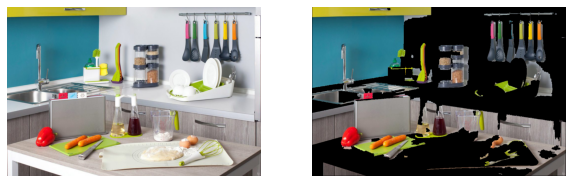

In [7]:
figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(im), axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(im)), axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfbac3a20>,
 (-0.5, 1023.5, 682.5, -0.5))

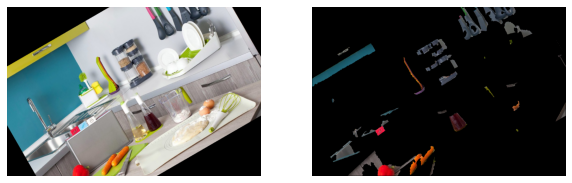

In [8]:
# поворот 
im_rot = im.rotate(30)

figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(im_rot), axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(im_rot)), axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfba61f60>,
 (-0.5, 599.5, 599.5, -0.5))

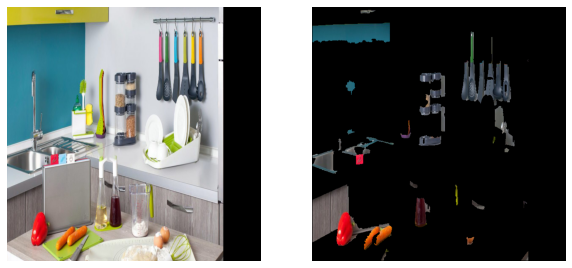

In [9]:
# скосы 
im_skos = im.transform((600,600),Image.AFFINE, (2,0,1,0,1,1))


figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(im_skos), axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(im_skos)), axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfb9a2d30>,
 (-0.5, 1023.5, 682.5, -0.5))

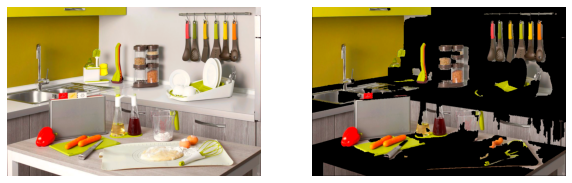

In [10]:
# изменение цвета 
im_dif_clr = im.convert('RGB') 

def transform(r, g, b):
    r, g, b = (max(r, g, b), g, min(r, g, b))
    avg_v = r * 0.2126 + g * 0.7152 + b * 0.0722
    r += (r - avg_v) * 0.6
    g += (g - avg_v) * 0.6
    b += (b - avg_v) * 0.6
    return r, g, b

lut_fltr = Color3DLUT.generate(17, transform)

im_dif_clr = im_dif_clr.filter(lut_fltr)



figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(im_dif_clr) , axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(im_dif_clr)) , axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfb98f5c0>,
 (-0.5, 599.5, 319.5, -0.5))

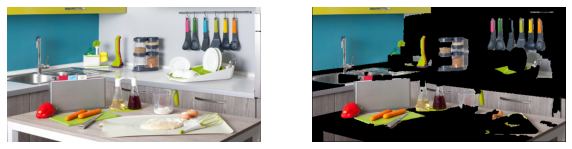

In [11]:
# Изменим разрешение. Уменьшим картинку
newsize = (600, 320)
im1 = im.resize(newsize)

figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(im1), axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(im1)), axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bfb82fa20>,
 (-0.5, 1023.5, 682.5, -0.5))

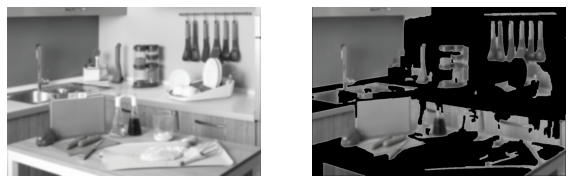

In [12]:
# Размытое изображение
iml_razm_ar = filters.gaussian_filter(im, 3)
iml_razm = Image.fromarray(uint8(iml_razm_ar))


figure(figsize=(10,10))
plt.subplot(1,2,1), imshow(iml_razm), axis('off')
plt.subplot(1,2,2), imshow(fn_watershed(iml_razm)), axis('off')

# Протестируйте различные алгоритмы сегментации skimage, сравните результаты (качество и быстродействие)

## Watershed

In [32]:
%%time
gradient = sobel(rgb2gray(img))

segments_watershed = watershed(gradient,
                               markers=50, 
                               compactness=0.0001)

CPU times: user 461 ms, sys: 4.01 ms, total: 465 ms
Wall time: 468 ms


In [ ]:
# segments_watershed = watershed(img, 
#           markers=None, 
#           connectivity=1, 
#           offset=None,
#           mask=None, 
#           compactness=0,
#           watershed_line=False)


## Сегментация на основе графов Фельзенцвальба

In [14]:
%%time
segments_fz = felzenszwalb(img,
                           scale=5000, 
                           sigma=0.5, 
                           min_size=50)

CPU times: user 1.16 s, sys: 53.9 ms, total: 1.22 s
Wall time: 1.22 s


## Quickshift

In [19]:
%%time
segments_quick = quickshift(img, 
                            kernel_size=20, 
                            max_dist=10000, 
                            ratio=0.5) 

CPU times: user 3min 53s, sys: 21 ms, total: 3min 53s
Wall time: 3min 53s


## SLIC

In [16]:
%%time
segments_slic = slic(img, 
                     n_segments=40,
                     compactness=10, 
                     sigma=1) 

CPU times: user 796 ms, sys: 995 µs, total: 797 ms
Wall time: 798 ms


#### Отрисовка

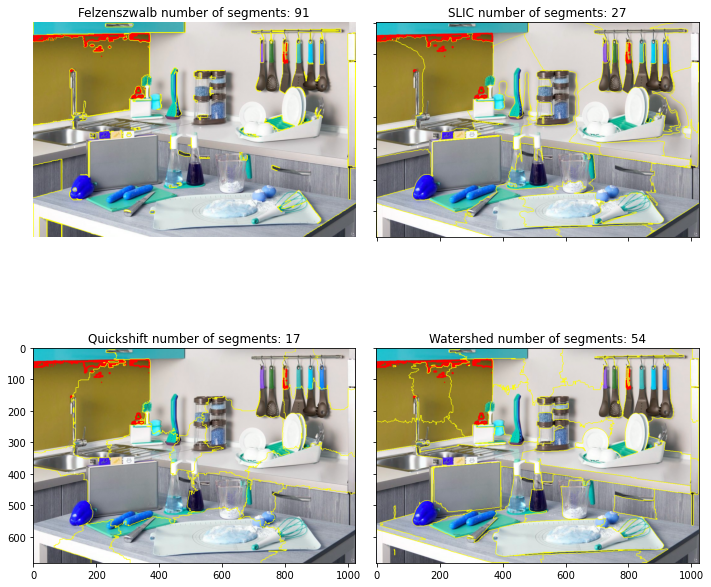

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
# количество сегментов

# print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
# print(f"SLIC number of segments: {len(np.unique(segments_slic))}") 
# print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
# print(f"Watershed number of segments: {len(np.unique(segments_watershed))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")

ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title(f"SLIC number of segments: {len(np.unique(segments_slic))}")

ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title(f"Watershed number of segments: {len(np.unique(segments_watershed))}")

for a in ax.ravel():
  a.set_axis_off()
  plt.tight_layout()
  plt.show()

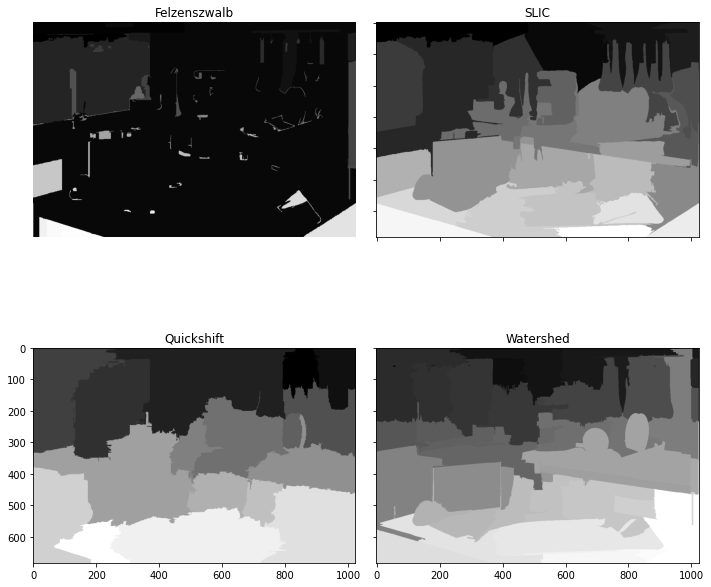

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(segments_fz, cmap='gray')
ax[0, 0].set_title("Felzenszwalb")

ax[0, 1].imshow(segments_slic, cmap='gray')
ax[0, 1].set_title("SLIC")

ax[1, 0].imshow(segments_quick, cmap='gray')
ax[1, 0].set_title("Quickshift")

ax[1, 1].imshow(segments_watershed, cmap='gray')
ax[1, 1].set_title("Watershed")

for a in ax.ravel():
  a.set_axis_off()
  plt.tight_layout()
  plt.show()